## 1. Cargar Serie de tiempo

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

serie = pd.read_csv("../data/processed/serie_preparada.csv", index_col=0, parse_dates=True)
metrica = "total_pkts"
plt.style.use("seaborn-v0_8")
#Asegurar que la columna de la serie temporal es numerica y no datetime
serie[metrica] = pd.to_numeric(serie[metrica], errors="coerce")

# Se agrega la frecuencia para filtrar warning
freq = pd.infer_freq(serie.index)
#print("Frecuencia inferida:", freq)

if freq is not None:
    serie = serie.asfreq(freq)
    serie.index.freq = freq
serie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2017-07-07 03:30:00 to 2017-07-07 05:02:00
Freq: min
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_pkts  93 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


## 2. Seleccionar Ventana Benigna


Rango temporal de la Ventana benigna
2017-07-07 03:30:00 -> 2017-07-07 03:55:00 n =  26

Observaciones de entrenamiento (benignas):  26
Observaciones restantes (validación + ataque):  66



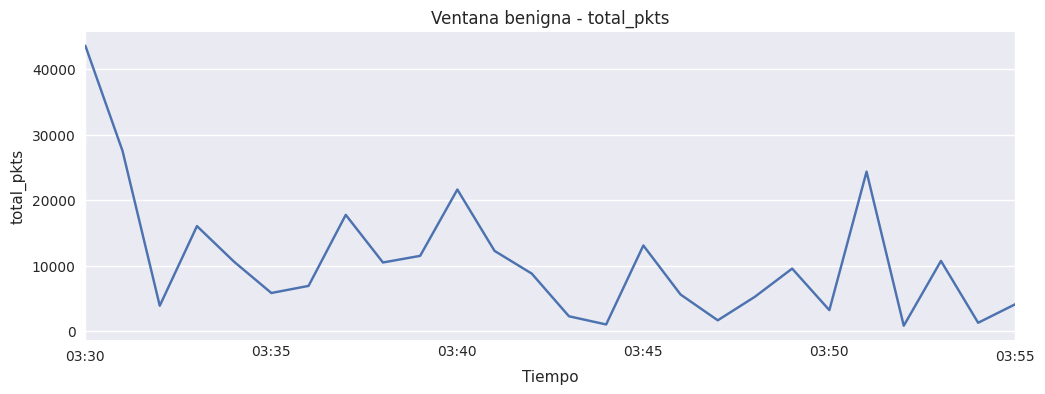

In [51]:
# Marca de cuando inicia el ataque DDoS en el dataset
inicio_ataque = pd.Timestamp("2017-07-07 03:56:00")

# Serie completa - Tráfico completo
serie_full = serie[metrica].copy()

# Serie de entrenamiento - Tráfico Normal
serie_train = serie_full[serie_full.index < inicio_ataque].copy()
print("\n" + "="*60)
print("Rango temporal de la Ventana benigna")
print(serie_train.index.min(), "->", serie_train.index.max(), "n = ", len(serie_train))

print("\nObservaciones de entrenamiento (benignas): ",len(serie_train))
print("Observaciones restantes (validación + ataque): ",len(serie_full[serie_full.index > inicio_ataque]))
print("\n" + "="*60)

plt.figure(figsize=(12,4))
serie_train.plot()
plt.title("Ventana benigna - total_pkts")
plt.xlabel("Tiempo")
plt.ylabel(metrica)
plt.show()

## 3. ENTRENAMIENTO (ARIMA, HOLT, SES)

### 3.1 ENTRENAMIENTO MODELO HOLT

In [52]:
modelo_holt = ExponentialSmoothing(serie_train,trend ="add", seasonal = None)
modelo_holt = modelo_holt.fit(optimized=True)
print("\n" + "="*80)
print(modelo_holt.summary())
print("\n" + "="*80)


                       ExponentialSmoothing Model Results                       
Dep. Variable:               total_pkts   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                     2131621957.851
Optimized:                         True   AIC                            481.773
Trend:                         Additive   BIC                            486.806
Seasonal:                          None   AICC                           486.194
Seasonal Periods:                  None   Date:                 Mon, 08 Dec 2025
Box-Cox:                          False   Time:                         03:52:14
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2277402                alpha                 True
smoothing_trend             0.000

**3.1.1 Predicción (IN-SAMPLE + OUT-OF-SAMPLE)**

**3.1.2 Predicción IN-SAMPLE**

In [53]:
# Generar predicción para la ventana de tráfico normal  
pred_train_holt = modelo_holt.fittedvalues
pred_train_holt.head()

timestamp
2017-07-07 03:30:00    26701.489845
2017-07-07 03:31:00    29676.284980
2017-07-07 03:32:00    28314.726542
2017-07-07 03:33:00    21884.482726
2017-07-07 03:34:00    19687.300636
Freq: min, dtype: float64

**3.1.3 Predicción OUT-OF-SAMPLE**

In [54]:
# Generar predicción desde el tráfico de atauqe en adelante 
n_full = len(serie_full)
n_train = len(serie_train)
n_out = n_full - n_train

pred_out_holt = modelo_holt.forecast(steps=n_out)
pred_out_holt.head()

2017-07-07 03:56:00    2635.745885
2017-07-07 03:57:00    1765.943336
2017-07-07 03:58:00     896.140786
2017-07-07 03:59:00      26.338237
2017-07-07 04:00:00    -843.464312
Freq: min, dtype: float64

**3.1.4 Unificar predicción IN-SAMPLE y OUT-OF-SAMPLE**

In [55]:
#Concatenar predicciones para cubrir toda la serie
pred_full_holt = pd.concat([pred_train_holt,pred_out_holt])

pred_full_holt.index = serie_full.index

pred_full_holt.name = "pred_holt"

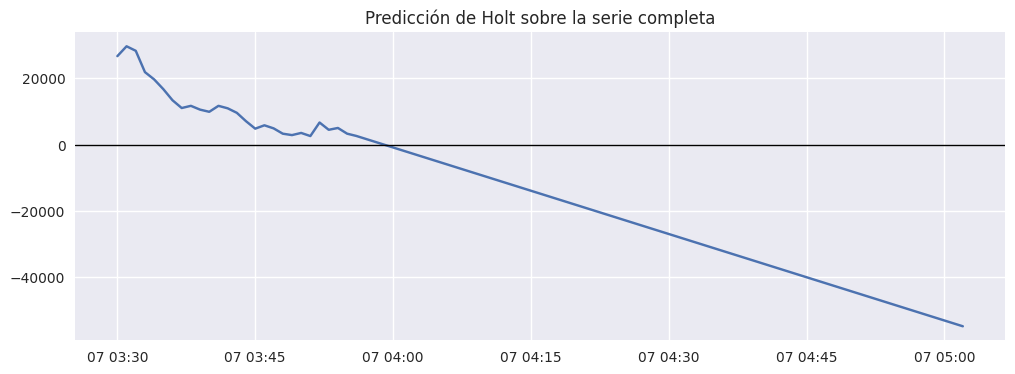

In [56]:
plt.figure(figsize=(12,4))
plt.plot(pred_full_holt)
plt.title("Predicción de Holt sobre la serie completa")
plt.axhline(0,color='black', linewidth=1)

**3.1.5 Calcular residuos Holt**

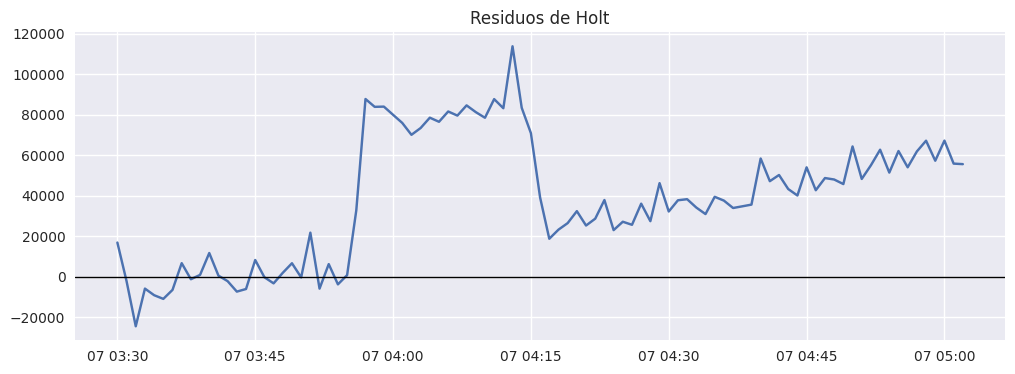

In [57]:
residuos_holt = serie_full - pred_full_holt
plt.figure(figsize=(12,4))
plt.plot(residuos_holt)
plt.title("Residuos de Holt")
plt.axhline(0,color='black', linewidth=1)

### 3.2 ENTRENAMIENTO MODELO SES

In [58]:
modelo_SES = ExponentialSmoothing(serie_train, trend=None, seasonal=None)
modelo_SES = modelo_SES.fit()
print(modelo_SES.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               total_pkts   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                     2309457682.732
Optimized:                         True   AIC                            479.857
Trend:                             None   BIC                            482.373
Seasonal:                          None   AICC                           481.761
Seasonal Periods:                  None   Date:                 Mon, 08 Dec 2025
Box-Cox:                          False   Time:                         03:52:18
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2842876                alpha                 True
initial_level              22870.1

**3.2.1 Predicción (IN-SAMPLE + OUT-OF-SAMPLE)**

**3.2.2 Predicción IN-SAMPLE**

In [59]:
# Generar predicciones dentro de la ventana benigna (IN-SAMPLE)
pred_train_SES = modelo_SES.fittedvalues
pred_train_SES.head()

timestamp
2017-07-07 03:30:00    22870.115921
2017-07-07 03:31:00    28758.532249
2017-07-07 03:32:00    28405.580012
2017-07-07 03:33:00    21438.662931
2017-07-07 03:34:00    19908.438547
Freq: min, dtype: float64

**3.2.3 Predicción OUT-OF-SAMPLE**

In [60]:
# Generar predicciones desde el ataque en adelante (OUT-OF-SAMPLE)
n_full = len(serie_full)
n_train = len(serie_train)
n_out = n_full - n_train

pred_out_SES = modelo_SES.forecast(steps=n_out)
pred_out_SES.head()

2017-07-07 03:56:00    6018.881961
2017-07-07 03:57:00    6018.881961
2017-07-07 03:58:00    6018.881961
2017-07-07 03:59:00    6018.881961
2017-07-07 04:00:00    6018.881961
Freq: min, dtype: float64

**3.2.4 Unificar predicción IN-SAMPLE y OUT-OF-SAMPLE**

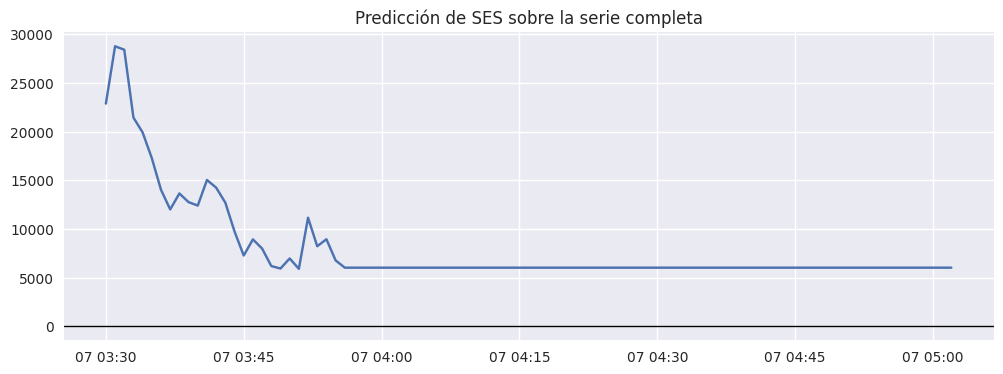

In [61]:
pred_full_SES = pd.concat([pred_train_SES, pred_out_SES])
pred_full_SES.index = serie_full.index
pred_full_SES.name = "pred_SES"

plt.figure(figsize=(12,4))
plt.plot(pred_full_SES)
plt.title("Predicción de SES sobre la serie completa")
plt.axhline(0,color='black', linewidth=1)


**3.2.5 Calcular residuos SES**

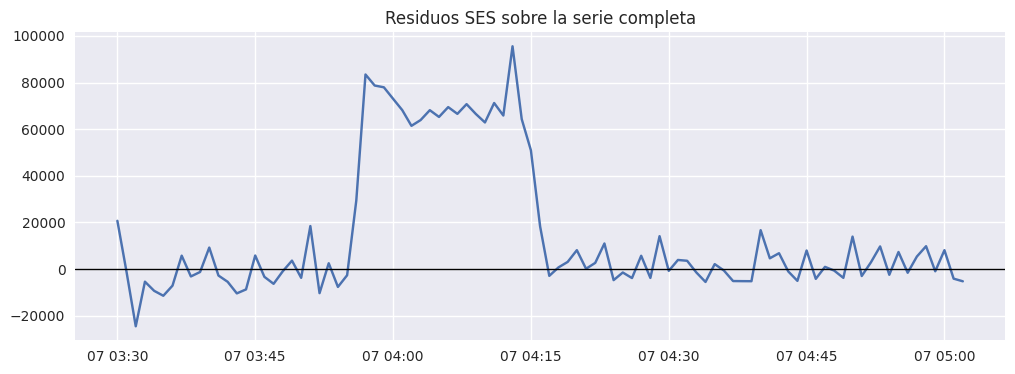

In [62]:
residuos_SES = serie_full- pred_full_SES

plt.figure(figsize=(12,4))
plt.plot(residuos_SES)
plt.title("Residuos SES sobre la serie completa")
plt.axhline(0, color='black', linewidth=1)

### 3.3ARIMA

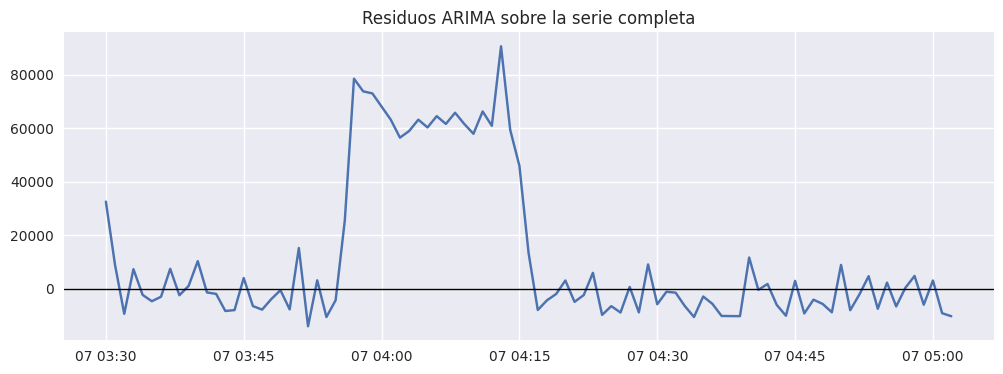

In [71]:
residuos_arima = pd.read_csv("../data/processed/residuos_arima.csv",index_col=0, parse_dates=True)
plt.figure(figsize=(12,4))
plt.plot(residuos_arima)
plt.title("Residuos ARIMA sobre la serie completa")
plt.axhline(0, color='black', linewidth=1)

In [72]:
### COMPARATIVA DE LOS 3 RESIDUOS

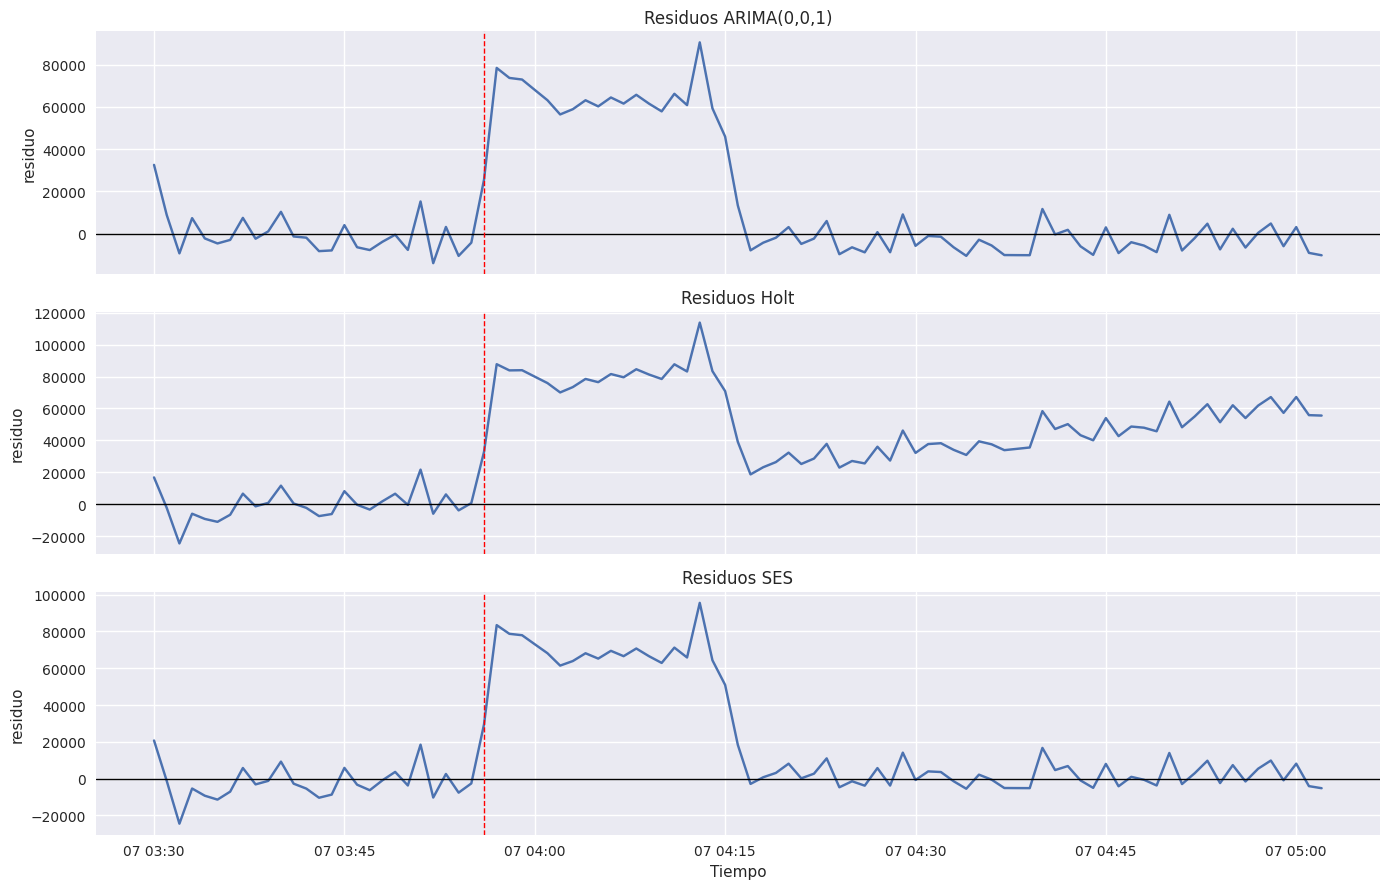

In [76]:
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# --- Residuos ARIMA ---
axes[0].plot(residuos_arima.index, residuos_arima.values)
axes[0].axhline(0, color="black", linewidth=1)
axes[0].set_title("Residuos ARIMA(0,0,1)")
axes[0].set_ylabel("residuo")

# --- Residuos Holt ---
axes[1].plot(residuos_holt.index, residuos_holt.values)
axes[1].axhline(0, color="black", linewidth=1)
axes[1].set_title("Residuos Holt")
axes[1].set_ylabel("residuo")

# --- Residuos SES ---
axes[2].plot(residuos_SES.index, residuos_SES.values)
axes[2].axhline(0, color="black", linewidth=1)
axes[2].set_title("Residuos SES")
axes[2].set_ylabel("residuo")
axes[2].set_xlabel("Tiempo")

plt.tight_layout()
ATTACK_TS = pd.Timestamp("2017-07-07 03:56:00")  # ajusta a tu caso

for ax in axes:
    ax.axvline(ATTACK_TS, color="red", linestyle="--", linewidth=1)

plt.show()